In [1]:
import pandas as pd
import re
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch
import transformers as ppb
import numpy as np
from numpy.linalg import norm
import xml.etree.ElementTree as ET

import time
import nltk

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.feature_selection import SelectFpr, chi2

from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import re as reg
from nltk.stem.isri import ISRIStemmer
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
df1=pd.read_csv(r"datasets\astd-artwitter.csv")
df2=pd.read_csv(r"datasets\LABR-book-reviews.csv")
df3=pd.read_csv(r"datasets\mpqa-ar.csv")
df=pd.concat([df1,df2,df3],axis=0)
df

,sentiment,txt
0,1,انشاء الله هنعمل حاجه
1,0,اقسم باللله ان العرب اكثر الشعوب تخلفاا
2,0,﻿هات ناس تفهم .. و المثل بحكي اسأل مجرب و لا ت...
3,0,صرماتي براس اهلك
4,0,حرام السخرية من الناس
...,...,...
9991,0,\nيوم الخميس في القمة العربية في العاصمة اللبن...
9992,1,NaN
9993,0,\nإذا واسمحوا لي انه يحصل لي أود أن يكون وقتا ...
9994,0,\nالجيش بحكمة أغلال السجناء أثناء النقل : وذلك...


AxesSubplot(0.125,0.125;0.775x0.755)


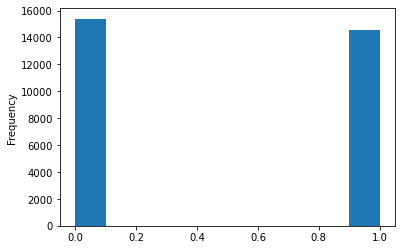

In [4]:
from matplotlib import pyplot as plt
histogram = df.sentiment.plot.hist()
print(histogram)
plt.show()

In [7]:


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
st = ISRIStemmer()

def translitArabic(text):  ### This method is to encode the Arabic characters using buckwalter
    buckwalterMod = {
            'ء': 'c', 'ا': 'A', 'إ': 'A',
        'أ': 'A', 'آ': 'A', 'ب': 'b',
        'ة': 'o', 'ت': 't', 'ث': 'v',
        'ج': 'j', 'ح': 'H', 'خ': 'x',
        'د': 'd', 'ذ': 'V', 'ر': 'r',
        'ز': 'z', 'س': 's', 'ش': 'E',
        'ص': 'S', 'ض': 'D', 'ط': 'T',
        'ظ': 'Z', 'ع': 'C', 'غ': 'g',
        'ف': 'f', 'ق': 'q', 'ك': 'k',
        'ل': 'l', 'م': 'm', 'ن': 'n',
        'ه': 'h', 'ؤ': 'c', 'و': 'w',
        'ى': 'y', 'ئ': 'c', 'ي': 'y',
        }
    for k, v in buckwalterMod.items():
        text = re.sub(k, v, text)
    return(text)
    

def normalize_arabic(text):  ### This method is to normalize the Arabic characters 
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text   

def deNormalize(text):    ### This method is to denormalize the Arabic characters 
    alifs           = '[إأٱآا]'
    alifReg         = '[إأٱآا]'
    # -------------------------------------
    alifMaqsura     = '[يى]'
    alifMaqsuraReg  = '[يى]'
    # -------------------------------------
    taMarbutas      = 'ة'
    taMarbutasReg   = '[هة]'
    # -------------------------------------
    hamzas          = '[ؤئء]'
    hamzasReg       = '[ؤئءوي]'
    # Applying deNormalization
    text = re.sub(alifs, alifReg, text)
    text = re.sub(alifMaqsura, alifMaqsuraReg, text)
    text = re.sub(taMarbutas, taMarbutasReg, text)
    text = re.sub(hamzas, hamzasReg, text)
    return text

## To find arabic Tashkeel
arabic_diacritics = re.compile("""  
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def modify_post(input_str):   ### This method is to perform the preprocessing operations 
    input_str = re.sub(r'http\S+', '', input_str)  #remove URL
    input_str = re.sub(r'[^\w\s]','',input_str)  #remove punctuation 
    input_str = re.sub('_+' , ' ', input_str)  #remove underscore 
    input_str = re.sub(r'\s+', ' ', input_str)   #remove newLine
    input_str = re.sub(arabic_diacritics, '', input_str)   #Tashkeel
    input_str = normalize_arabic(input_str)      # Normalization
    input_str= re.sub('[0-9]+', 'ارقام', input_str)   #Replace digits  
 

    pattern=reg.compile(r"(.)\1{1,}",reg.DOTALL)
    input_str=pattern.sub(r"\1",input_str)   #remove duplicate ch
 
    input_str = ' '.join([st.stem(w) for w in nltk.word_tokenize(input_str)])   #Stem Arabic
 
    return input_str




In [8]:
print("Preprocessing ..........")

df=df[df['txt'].map(type) == str]      ### to convert all post body  to sting, this is necessary for blank posts
df['txt'] = df['txt'].str.lower()      ### to conver all ch to lower case
print("The number of all records is: ",len(df))
df= df.reset_index(drop=True)
df['txt']=df['txt'].apply(modify_post)

Preprocessing ..........
The number of all records is:  29852


In [9]:
### Spliting the data
msg_train,msg_test,type_train,type_test = train_test_split(df['txt'], df['sentiment'], test_size = 0.1, random_state=0)

In [10]:
##############################################################################################################



seed = 1075
np.random.seed(seed)

print('###################################################################')
print('                       Training the Classifier                     ')
print('###################################################################')
start = time.time()

##### Training pipeline ############## 
##### Feature Extraction using CountVectorizer
##### Calculating the frequency of the feature using TfidfTransformer
##### Features selection and normalizing 
##### Training the classifier 

pipeline = Pipeline([
    ('bow',CountVectorizer(max_features=20000,ngram_range=(1,3))),   #,stop_words='english'  ,ngram_range=(1,2) max_features=400000,  max_df=1000,max_df=50000,min_df=4,
     ('tfidf',TfidfTransformer()),
    
     # Features selection and normalizing 
    
     #('fese', SelectFromModel(LinearSVC())),#SelectKBest(chi2, k=80000)),#SelectFpr(f_classif)),#chi2, alpha=0.01)),
     #('den', densify()),
     #('ss',preprocessing.Normalizer()),
     #('ss',MaxAbsScaler()),
     #('fese', SelectKBest(chi2, k=50000)),
    
     #### Use one classifier among many  #####
    
     #('classifier',SGDClassifier(loss='hinge',alpha=1e-5,max_iter=15,verbose=False )    )])   #'modified_huber',  #' #
     #('classifier', BaggingClassifier(  SGDClassifier(loss='hinge',alpha=1e-5,max_iter=15,verbose=False )   
     #                             , max_samples=0.6, random_state=seed)  )])
     #('classifier', PassiveAggressiveClassifier( )  )]) #RidgeClassifier()  , ComplementNB
     #('classifier',VotingClassifier(estimators=[('sg',SGDClassifier(loss='hinge',alpha=1e-5,max_iter=15,verbose=False )),
     #                                         ('rg', RidgeClassifier()),('cnb', ComplementNB())  ],
     #                                          voting='hard')   )])  # , ('ps', PassiveAggressiveClassifier( )
     #('classifier', ComplementNB()  )])
     #('classifier',EnsembleVoteClassifier(clfs=[ SGDClassifier(loss='modified_huber',alpha=1e-5,max_iter=15,verbose=False ), 
     #                  ComplementNB(), ], voting='soft')    )]) #
     
     #
     #('classifier', RidgeClassifier( )  )]) 
     ('classifier', MultinomialNB( )  )]) 
     #('classifier', LinearSVC( )  )]) 

#### Fitting the pipeline ###################

pipeline.fit(msg_train,type_train)

#### Find the predictions ####################
predictions = pipeline.predict(msg_test)
print(classification_report(type_test,predictions))

end = time.time()
print('The Total Training and test time is:  ',end - start) 

#### Preparing the Pickle  #####################


###################################################################
                       Training the Classifier                     
###################################################################
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1546
           1       0.85      0.75      0.80      1440

    accuracy                           0.82      2986
   macro avg       0.82      0.82      0.82      2986
weighted avg       0.82      0.82      0.82      2986

The Total Training and test time is:   7.7851293087005615
